# **Setting & Introduction**

## **1. Github 연동**

In [1]:
""" github 연동 """
!git clone https://github.com/ku-sungsukim/2025-LGElec-Day22.git ### colab 사용 시

Cloning into '2025-LGElec-Day22'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 55 (delta 8), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (55/55), 19.53 MiB | 8.41 MiB/s, done.
Resolving deltas: 100% (8/8), done.


## **2. About Jupyter Notebook**

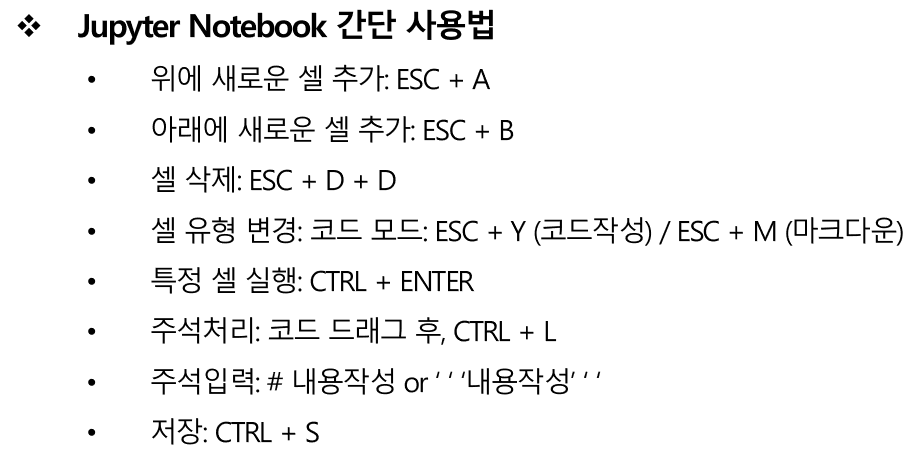

In [2]:
""" 설명 장표 불러오기 """
from IPython.display import Image
# Image('image/1-Introduction2.PNG') ### 로컬 사용 시
Image('/content/2025-LGElec-Day22/image/1-Introduction2.PNG') ### colab 사용 시

## **[Data Balancing & XAI 실습 목차]**
 - (1) Data Balancing (1) - UnderSampling

 - ***(2) Data Balancing (2) - Oversampling √***

 - (3) XAI

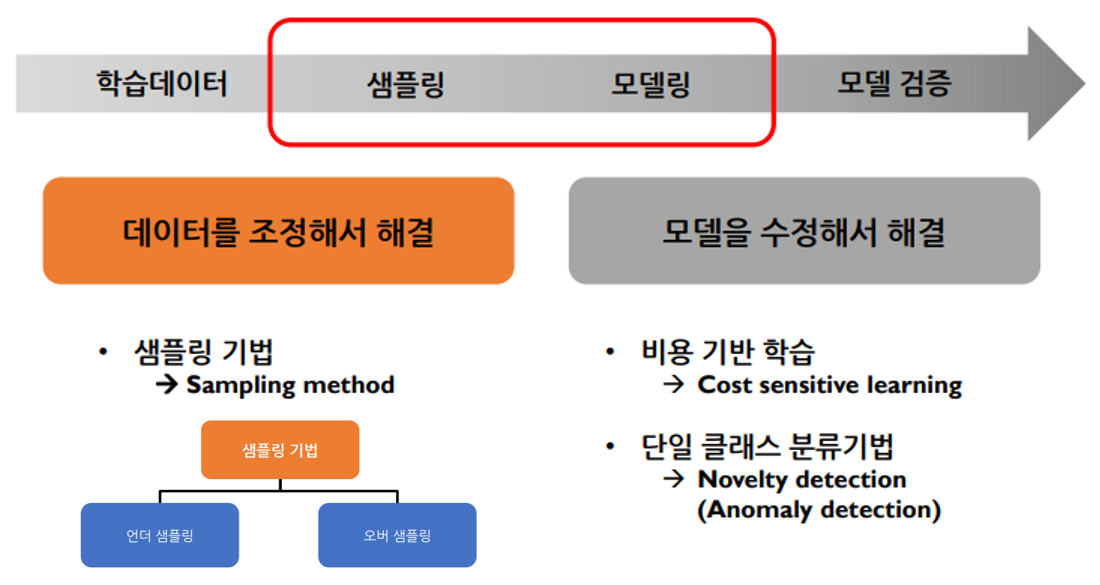

In [3]:
""" 설명 장표 불러오기 """
# Image('image/3-DataBalancing1.PNG') ### 로컬 사용 시
Image('/content/2025-LGElec-Day22/image/3-DataBalancing1.PNG') ### colab 사용 시

## **[Data Balancing - OverSampling - Pytorch 목차]**

  - SequentialSampler

  - RandomSampler

  - WeightedRandomSampler

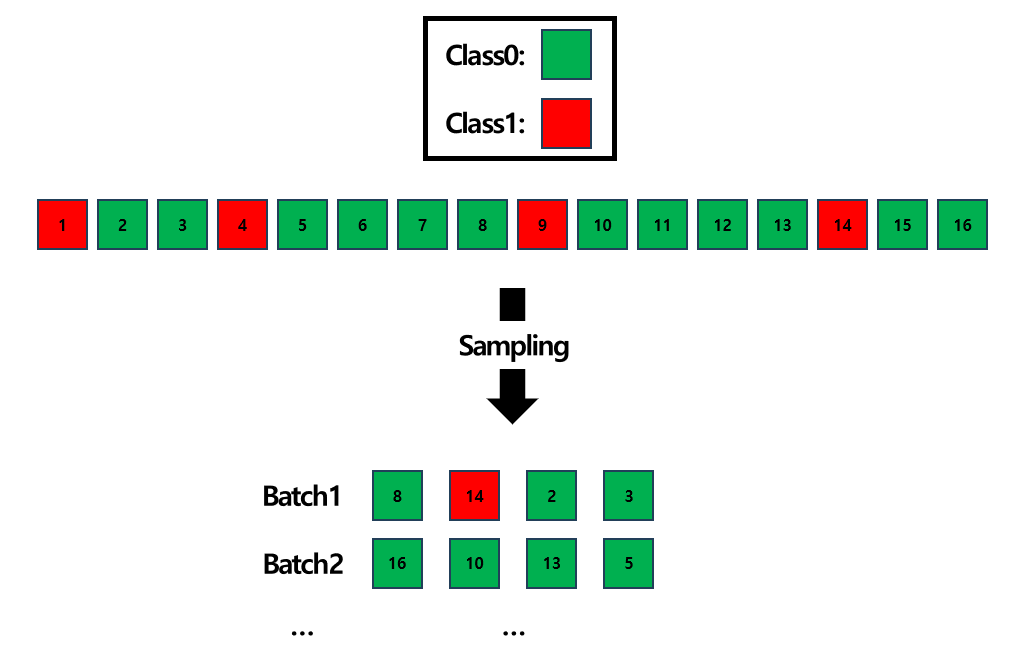

In [4]:
""" 설명 장표 불러오기 """
# Image('image/6-torchOverSampling2.PNG') ### 로컬 사용 시
Image('/content/2025-LGElec-Day22/image/6-torchOverSampling2.PNG') ### colab 사용 시

## **0. 모델링 환경 설정**

#### **0-1. 필요 패키지 불러오기**

In [5]:
""" 실습에 필요한 패키지 불러오기 """


""" 기본 연산과 관련된 패키지 """
import numpy as np
import pandas as pd


""" 모델링 및 성능 산출과 관련된 패키지"""
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


""" pytorch 패키지 """
import torch
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler, WeightedRandomSampler


""" 경고 숨기기 """
import warnings
warnings.filterwarnings('ignore')

#### **0-2. 필요 함수 사전 정의**

In [6]:
""" (1) 실습 데이터셋을 생성하는 함수 """
def create_dataset(n_samples=2000, n_classes=2, weights=(0.8, 0.2), n_cluster=1, class_sep=1, random_state=2025):

    ### 데이터셋 생성
    df = make_classification(n_samples=n_samples, ### Instance 개수
                                n_features=2, ### 변수 개수
                                n_redundant=0, ### 선형결합으로 생성 가능한 겹치는 변수 개수
                                n_classes=n_classes, ### Class 개수
                                weights=list(weights), ### 클래스 비율
                                n_clusters_per_class=n_cluster, ### Class 당 군집 개수
                                class_sep=class_sep, ### 클래스 군집 간 간격 (클수록 멀어짐)
                                random_state=random_state)

    ### X, y 구분
    X = pd.DataFrame(df[0], columns=['X1', 'X2'])
    y = pd.DataFrame(df[1], columns=['y'])
    return X, y

## **1. Pytorch Sampler**

#### **1-1. 실습 데이터 생성**
 - https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [7]:
""" 데이터 생성 """
X_syn, y_syn = create_dataset(n_samples=5000,
                               n_classes=2,
                               weights=(0.9, 0.1),
                               n_cluster=1,
                               class_sep=1,
                               random_state=2025)

print(X_syn.shape, y_syn.shape)

(5000, 2) (5000, 1)


In [8]:
""" 데이터 형태 확인 """
pd.concat((X_syn, y_syn),axis=1)

,X1,X2,y
0,-0.531085,1.105561,0
1,-1.337406,1.832934,0
2,-0.661052,-0.289082,0
3,-0.845163,0.659521,0
4,-1.137641,0.484028,0
...,...,...,...
4995,-1.423838,1.201032,0
4996,-0.702077,0.952859,0
4997,-0.603809,1.530758,0
4998,-0.725557,1.198236,0


In [9]:
""" 데이터 불균형 비율 확인 """
class0_count = y_syn[y_syn['y']==0].shape[0]
class1_count = y_syn[y_syn['y']==1].shape[0]
print(f'Number of Class0: {class0_count}개')
print(f'Number of Class1: {class1_count}개')
print(f'Class0 / Class1 = {round(class0_count/class1_count, 3)}%')

Number of Class0: 4475개
Number of Class1: 525개
Class0 / Class1 = 8.524%


In [10]:
""" Train/Test 분할 """
X_train, X_test, y_train, y_test = train_test_split(X_syn, y_syn, random_state=2025)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3750, 2), (1250, 2), (3750, 1), (1250, 1))

#### **1-2. Custom Dataset 정의**

In [11]:
""" pytorch 스타일 Custom Dataset 정의 """
class CustomDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X.to_numpy()
        self.y = y.to_numpy()

    ### 호출 시 Index에 대응하는 X, y를 반환
    def __getitem__(self, index):
        X = torch.FloatTensor(self.X[index])
        y = torch.LongTensor(self.y[index])
        return X, y, index

    def __len__(self):
        return len(self.y)

In [12]:
""" Custom Dataset 활용 예시 """
mydataset = CustomDataset(X_train, y_train)
mydataset

#### **1.3 SequentialSampler**

 - Index를 순서대로 호출

 - Class 불균형을 고려하지 않음

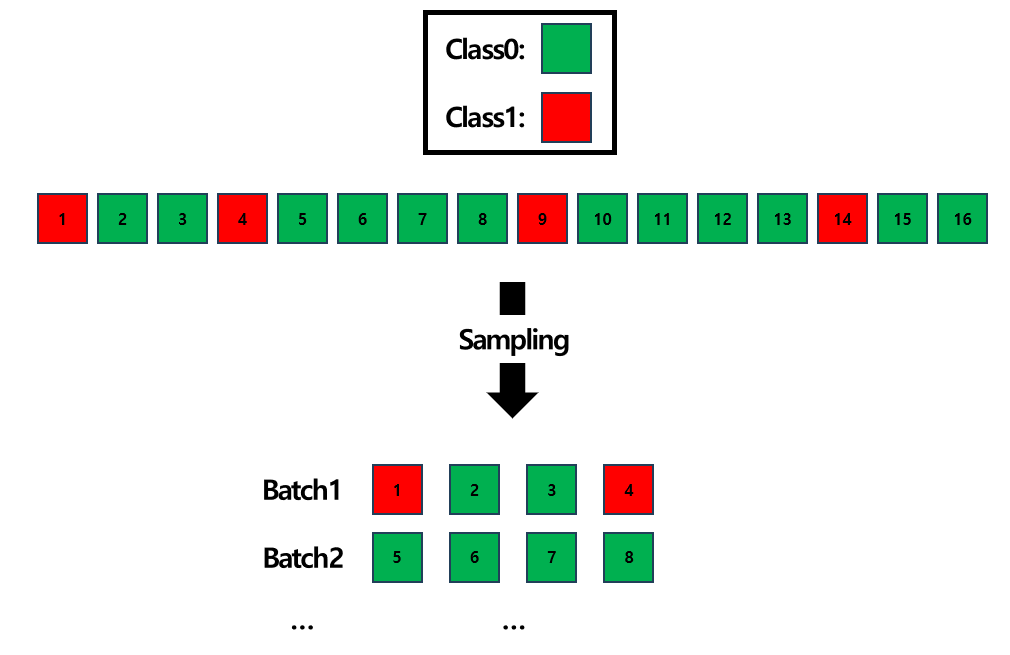

In [13]:
""" 설명 장표 불러오기 """
# Image('image/6-torchOverSampling1.PNG') ### 로컬 사용 시
Image('/content/2025-LGElec-Day22/image/6-torchOverSampling1.PNG') ### colab 사용 시

In [14]:
""" pytorch SequentialSampler 정의 """
sequential_sampler = SequentialSampler(data_source=mydataset)

In [15]:
""" SequentialSampler를 반영한 DataLoader 정의 """
dataloader = DataLoader(dataset=mydataset,
                        batch_size=256,
                        sampler=sequential_sampler,
                        drop_last=True)

In [16]:
""" 배치 단위 샘플링을 직접 하면서 Class0과 Class1의 비율 및 Sampling Index 확인 """

### 배치 내 Class0와 Class1의 비율 및 Index 파악
ratio_list = []
index_list = []
for epoch in range(3):
    for (X, y, index) in dataloader:
        num_class0 = (y==0).sum().item()
        num_class1 = (y==1).sum().item()
        ratio_list.append(num_class0/num_class1)
        index_list.extend(index.tolist())

### 비율들의 평균
print(f'Average(Class0 / Class1) = {round(np.mean(ratio_list), 3)}')

### Index 확인
print(f'Index 상위 10개: {index_list[:10]}')

Average(Class0 / Class1) = 8.569
Index 상위 10개: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


#### **1.4 RandomSampler**

 - Index를 랜덤하게 호출

 - Class 불균형을 고려하지 않음

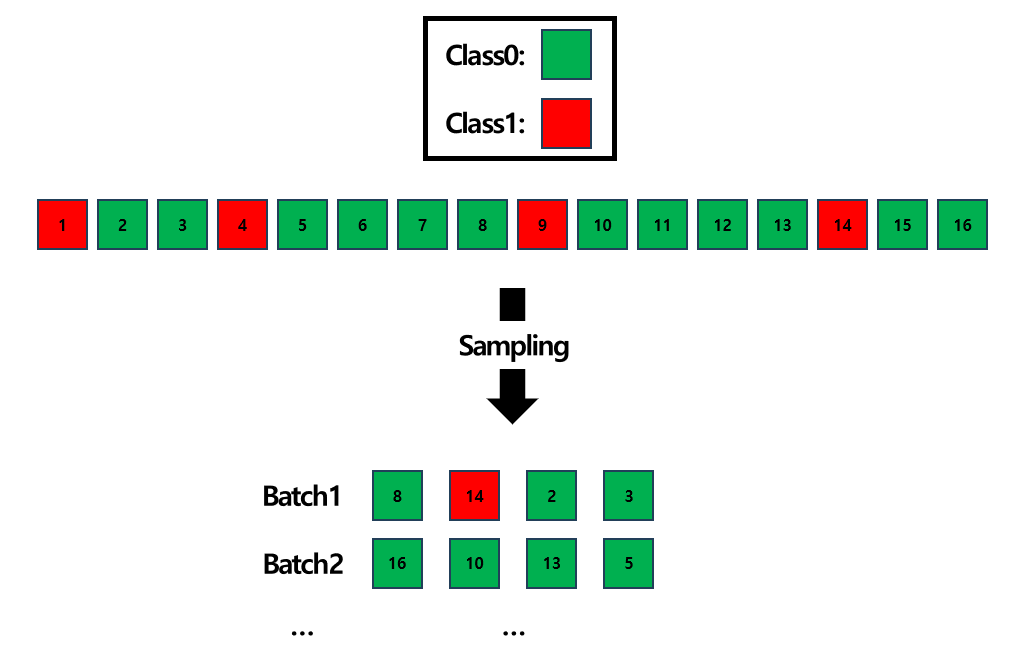

In [17]:
""" 설명 장표 불러오기 """
# Image('image/6-torchOverSampling2.PNG') ### 로컬 사용 시
Image('/content/2025-LGElec-Day22/image/6-torchOverSampling2.PNG') ### colab 사용 시

In [18]:
""" pytorch RandomSampler 정의 """
random_sampler = RandomSampler(data_source=mydataset)

In [19]:
""" RandomSampler를 반영한 DataLoader 정의 """
dataloader = DataLoader(dataset=mydataset,
                        batch_size=256,
                        sampler=random_sampler,
                        drop_last=True)

In [20]:
""" 배치 단위 샘플링을 직접 하면서 Class0과 Class1의 비율 및 Sampling Index 확인 """

### 배치 내 Class0와 Class1의 비율 및 Index 파악
ratio_list = []
index_list = []
for epoch in range(3):
    for (X, y, index) in dataloader:
        num_class0 = (y==0).sum().item()
        num_class1 = (y==1).sum().item()
        ratio_list.append(num_class0/num_class1)
        index_list.extend(index.tolist())

### 비율들의 평균
print(f'Average(Class0 / Class1) = {round(np.mean(ratio_list), 3)}')

### Index 확인
print(f'Index 상위 10개: {index_list[:10]}')

Average(Class0 / Class1) = 8.653
Index 상위 10개: [991, 1483, 2439, 497, 988, 2316, 915, 691, 2184, 2506]


#### **1.5 WeightedRandomSampler**

 - Index를 랜덤하게 호출

 - Class 불균형을 고려

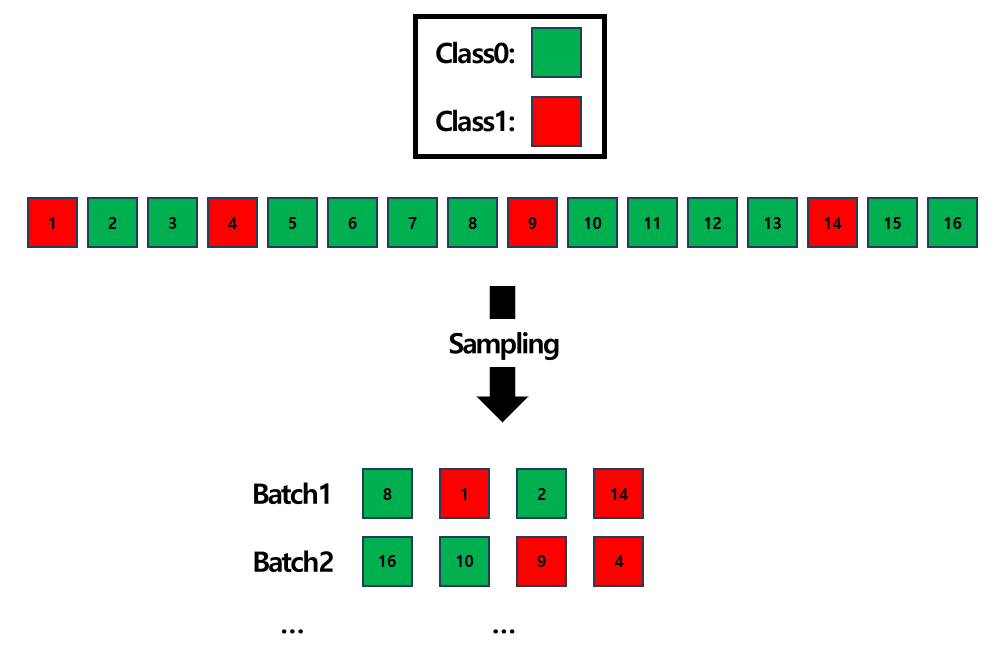

In [21]:
""" 설명 장표 불러오기 """
# Image('image/6-torchOverSampling3.PNG') ### 로컬 사용 시
Image('/content/2025-LGElec-Day22/image/6-torchOverSampling3.PNG') ### colab 사용 시

In [22]:
""" 각 Class 별 가중치 산정 """

### 전체 Sample 개수
num_samples = len(y_train)
print(f'전체 샘플 개수: {num_samples}\n')

### Class 개수 식별
class_counts = y_train.value_counts().to_list()
print(f'[Class0 개수, Class1 개수]: {class_counts}\n')

### Class 별 가중치를 다르게 부여

"""
Class 1에 가중치를 높게 부여
 - Class0 가중치: All / Class0
 - Class1 가중치: All / Class1
"""

class_weights = [round(num_samples / class_counts[i], 3) for i in range(len(class_counts))]
print(f'[Class0 가중치, Class1 가중치]: {class_weights}')

전체 샘플 개수: 3750

[Class0 개수, Class1 개수]: [3349, 401]

[Class0 가중치, Class1 가중치]: [1.12, 9.352]


In [23]:
""" 각 Sample 별 Label에 맞게 가중치 할당 """
labels = y_train.values.reshape(-1)
weights = [class_weights[labels[i]] for i in range(num_samples)]

pd.DataFrame({'label':labels[:10],
              'weight':weights[:10]})

,label,weight
0,0,1.120
1,0,1.120
2,0,1.120
3,1,9.352
4,0,1.120
5,0,1.120
6,0,1.120
7,0,1.120
8,0,1.120
9,0,1.120


In [24]:
""" pytorch WeightedRandomSampler 정의 """
weights = torch.DoubleTensor(weights)
weightedrandom_sampler = WeightedRandomSampler(weights, num_samples)

In [25]:
""" WeightedRandomSampler를 반영한 DataLoader 정의 """
dataloader = DataLoader(dataset=mydataset,
                        batch_size=256,
                        sampler=weightedrandom_sampler,
                        drop_last=True)

In [26]:
""" 배치 단위 샘플링을 직접 하면서 Class0과 Class1의 비율 및 Sampling Index 확인 """

### 배치 내 Class0와 Class1의 비율 및 Index 파악
ratio_list = []
index_list = []
for epoch in range(3):
    for (X, y, index) in dataloader:
        num_class0 = (y==0).sum().item()
        num_class1 = (y==1).sum().item()
        ratio_list.append(num_class0/num_class1)
        index_list.extend(index.tolist())

### 비율들의 평균
print(f'Average(Class0 / Class1) = {round(np.mean(ratio_list), 3)}')

### Index 확인
print(f'Index 상위 10개: {index_list[:10]}')

Average(Class0 / Class1) = 0.988
Index 상위 10개: [2450, 3713, 2310, 272, 2680, 1689, 2408, 3216, 1990, 3253]
